<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# Musterlösung / Sample solution 
## 6th exercise: <font color="#C70039">Domain Adaption with Autoencoders</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>

* **Student: Tzu-Lun Yeh**
* **Matriculation Number: 11496498**
* **Date: 29.10.2025**

---------------------------------

### Description 
This is one implementation example to demo the image reconstruction using autoencoders for domain adaption. 
Please do not miss to try different optimizers and losses.

---------------------------------

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
from   tqdm import tqdm
import time

SIZE=256

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# import input img
input_img_data=[]
input_path = './data/heisenberg_heisenberg/gernot/'
files=os.listdir(input_path)
# read all images in the folder (different rotations and flips of the original)
for i in tqdm(files):
    img=cv2.imread(input_path+'/'+i,1)   #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    input_img_data.append(img_to_array(img))
# -----------------------------------------  
# import output_img
output_img_data=[]
output_path = './data/heisenberg_heisenberg/walter/'
files=os.listdir(output_path)
# read all images in the folder (same rotations and flips as img)
for i in tqdm(files):
    img=cv2.imread(output_path+'/'+i,1)  #Change 0 to 1 for color images
    img=cv2.resize(img,(SIZE, SIZE))
    output_img_data.append(img_to_array(img))

input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
input_img_array = input_img_array.astype('float32') / 255. # normalize
output_img_array= np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
output_img_array = output_img_array.astype('float32') / 255. # normalize

# Original image for prediction of output_img 
# this one does not belong to the training set
test_img_data=[]

test_img=cv2.imread('./data/heisenberg_heisenberg/gernot-heisenberg-original.jpg', 1)   #Change 0 to 1 for color images
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)#Changing BGR to RGB to show images in true colors
test_img=cv2.resize(test_img,(SIZE, SIZE))
test_img_data.append(img_to_array(test_img))

test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
test_img_array = test_img_array.astype('float32') / 255. # normalize

# set the start time
# later needed for calculating the computation time
start=time.time()

100%|██████████| 50/50 [00:00<00:00, 2466.34it/s]


## Build the autoencoder-decoder model

In [3]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()


/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-29 20:26:07.047875: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-29 20:26:07.047914: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-29 20:26:07.047942: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-29 20:26:07.047968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-29 20:26:07.047988: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#callbacks = [tf.keras.callbacks.TensorBoard(log_dir='einstein_logs')]

# fit the model of input_img to output_img 
epochs = 50 #5000
model.fit(input_img_array, output_img_array, epochs=epochs, shuffle=True)#, callbacks=callbacks)

# print out the computation time
finish=time.time()
print('total computation time = ', finish-start)

# save the model
model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".keras")

Epoch 1/50


2025-10-29 20:26:07.805724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.9045 - loss: 0.1252
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8819 - loss: 0.0920
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9432 - loss: 0.0879
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9510 - loss: 0.0825
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9570 - loss: 0.0773
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9582 - loss: 0.0794
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9589 - loss: 0.0789
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9586 - loss: 0.0760
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.9590 - loss: 0.0753
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9569 - loss: 0.0732
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.9557 - loss: 0.0719
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9561 - loss: 0.0719
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━

output of test image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


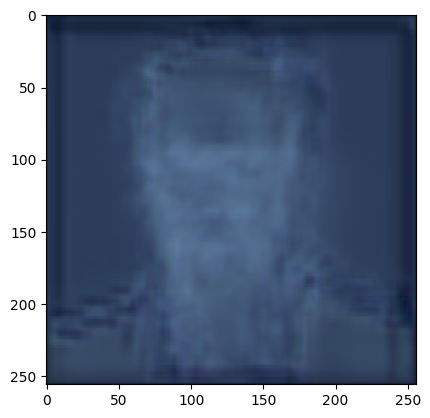

: 

In [ ]:
# predict the original image as test image, 
# since it did not belong to the training data.
# if the domain was really adapted, then the result would look like output_img
print("output of test image")

# load the model here
model = tf.keras.models.load_model("domain_adapt_autoenc_epochs.50.keras")

# now predict and see how it adapts to the new domain
pred = model.predict(test_img_array)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.show()

---
Learning Notes

**1. Why padding='same' keeps the same size?**

True purpose of convolution:
- Wrong: Convolution shrinks images to make them easier to process
- Correct: Convolution extracts features (edges, textures, shapes)

Design philosophy: Clear separation of duties

Conv2D (padding='same'):
- Responsibility: Extract features
- NOT responsible for: Changing dimensions

MaxPooling2D / UpSampling2D:
- Responsibility: Change dimensions  
- NOT responsible for: Feature extraction

Benefits:
- Clear architecture (see MaxPool = size changes there)
- Preserve edge information (no loss from stacking layers)
- Easy symmetric Encoder/Decoder design

Comparison:

padding='valid' (no padding):
256 → Conv2D → 254 → Conv2D → 252
- Lose edge information after stacking multiple layers

padding='same' (zero padding):
256 → Conv2D → 256 → Conv2D → 256
256 → MaxPool → 128 (Only shrink when needed)
- Edge information fully preserved

Where does convolution result go?
- Result goes to center position

3×3 kernel scanning:
┌───┬───┬───┐
│ █ │ █ │ █ │  ← These 9 pixels weighted sum
├───┼───┼───┤  → Result goes to center position
│ █ │ X │ █ │
├───┼───┼───┤
│ █ │ █ │ █ │
└───┴───┴───┘
     ↑
  Center position

---

**2. Why filters are 32→8→8, not continuously decreasing?**

Sample Solution design:
```python
Conv2D(32, ...)  → 32 filters  (Initial broad feature search)
Conv2D(8, ...)   → 8 filters   (Filter important features)
Conv2D(8, ...)   → 8 filters   (Continue refining)
Conv2D(8, ...)   → 8 filters   (Continue refining)
```

Why not continuously decrease?

If continuously decreasing: 32 → 16 → 8 → 4 → 2

Problems:
- 2-4 filters insufficient to capture complex features
- Too aggressive compression, poor reconstruction quality
- Network loses expressive power

Keeping 8 filters:
- Give network enough "feature capacity"
- 8 filters continuously refine features
- Avoid losing information too fast

Strategy:
- Spatial dimension (MaxPool):  256 → 128 → 64 → 32
- Feature dimension (Filters):  32  → 8   → 8  → 8
- Broad → Filter → Refine → Refine

---

**3. What does shuffle=True do during training?**

Function:
```python
model.fit(input_img_array, output_img_array, 
          epochs=50, 
          shuffle=True)  # Randomly shuffle image order each epoch
```

Comparison:

shuffle=False (sequential):
- Epoch 1: img1 → img2 → img3 → ... → img50
- Epoch 2: img1 → img2 → img3 → ... → img50  (Same order)
- May memorize "img2 always follows img1"
- Overfit to sequential patterns

shuffle=True (random):
- Epoch 1: img23 → img5 → img41 → img12 → ...
- Epoch 2: img8 → img33 → img2 → img47 → ...  (Different order)
- See different combinations each epoch
- Reduce overfitting
- Better generalization

Real scenario:

If data arranged as:
- img1-25: Looking left
- img26-50: Looking right

shuffle=False:
- First half of each epoch is "left", second half is "right"
- May learn "after seeing left, next should be left"

shuffle=True:
- Randomly mix "left" and "right"
- Learn "regardless of order, convert correctly"